C:\Users\junka\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(144879, 199) (62091, 199) (144879,) (62091,)
score= 0.6750253659950718
[3.50707810e-02 2.30742752e-01 1.58811101e-01 9.69195292e-05
 0.00000000e+00 0.00000000e+00 2.77095603e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.29870047e-03
 7.67638063e-03 0.00000000e+00 0.00000000e+00 9.52794058e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.33016278e-04 0.00000000e+00
 2.09143949e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.02587494e-03
 7.03440515e-03 2.30263896e-02 0.00000000e+00 8.04301672e-03
 6.45899611e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.40386380e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.39750219e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.41854324e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.17201244e-

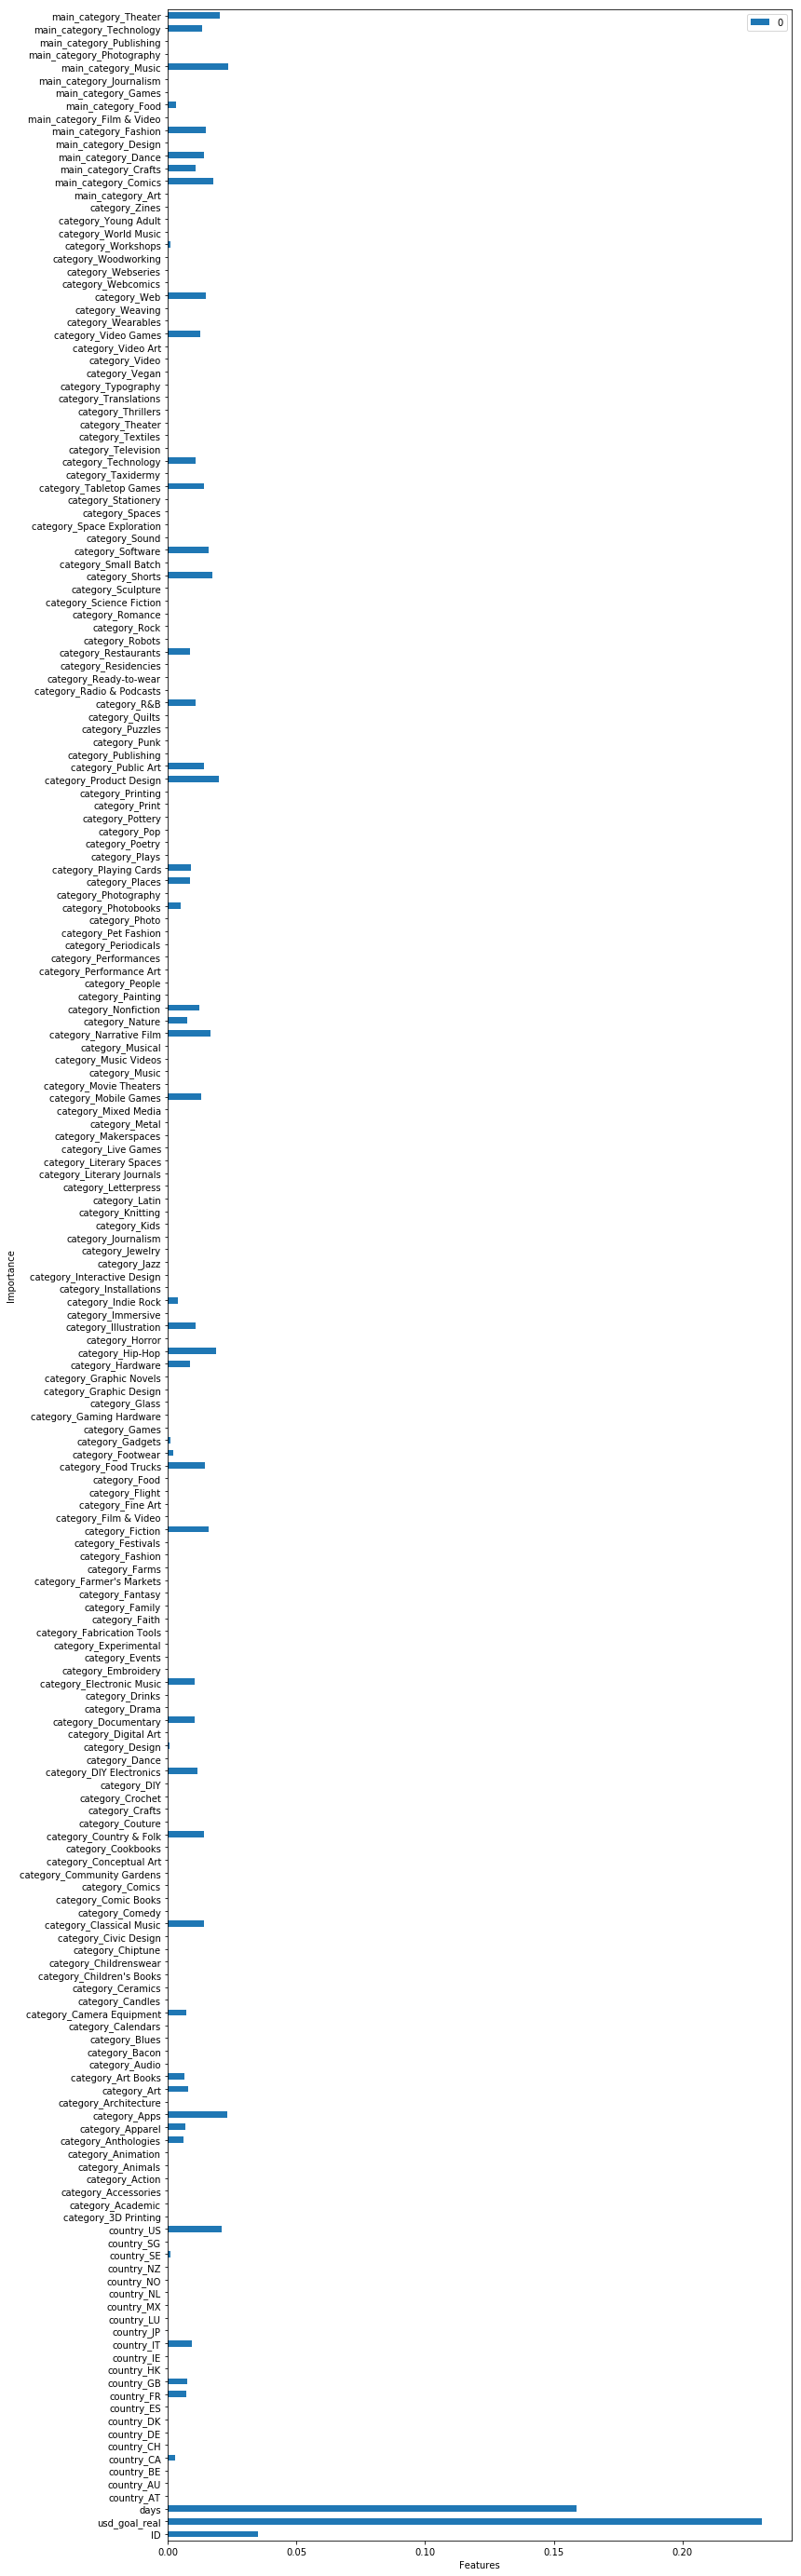

In [1]:
#********************************************************************
# pandas,numpy,matplotlib,codecs,sklearnの各ライブラリをインポート
#********************************************************************

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs as cd
from sklearn.preprocessing import LabelEncoder
# ホールドアウト法に関する関数
from sklearn.model_selection import train_test_split
# 交差検証法に関する関数
#from sklearn.model_selection import KFold
# 回帰問題における性能評価に関する関数
#from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#********************************************************************
#.該当課題のデータを読み込む
#********************************************************************
#201801のデータを読み込んでみる
with cd.open('ks-projects-201801.csv', 'r', 'utf-8', 'ignore') as f18:
    df_f18 = pd.read_csv(f18)
#df_f18 = pd.read_csv('ks-projects-201801.csv')

#********************************************************************
#.欠損値がある行は、とりあえずなくしてみる
#********************************************************************
#１個でも欠損値がある行はとりあえず削除してみる。
df_f18_dna = df_f18.dropna(how='any')

#********************************************************************
#.成功（'successful'）と失敗（'failed'）に絞って考える。
#********************************************************************
#成功だけを抽出したDFと失敗だけを抽出したDF
df_f18_success = df_f18_dna[df_f18_dna['state']=='successful']
df_f18_failed =  df_f18_dna[df_f18_dna['state']=='failed']
#両方を結合
df_f18_SorF = pd.concat([df_f18_success,df_f18_failed])

#********************************************************************
#.'state'をカテゴリ変数（文字列）から数値化してみる。
#********************************************************************
#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#stateに出てくるカテゴリを覚えて
#stateを数値に変換
le = le.fit(df_f18_SorF['state'])
df_f18_SorF['state'] = le.transform(df_f18_SorF['state'])

#********************************************************************
#.'deadline' 'launched' の項目から期間'days'を日数で割り出す
#********************************************************************
# 'deadline' 'launched' の項目をdatetimeに変更
df_f18_SorF['deadline'] = pd.to_datetime(df_f18_SorF['deadline'], errors = 'coerce')
df_f18_SorF['launched'] = pd.to_datetime(df_f18_SorF['launched'], errors = 'coerce')
# 'deadline' 'launched' の間の日数を示す'period'を作成
df_f18_SorF['period'] = df_f18_SorF['deadline'] - df_f18_SorF['launched']

days = []

#'period'の日数を'days'に抽出
for i in df_f18_SorF.index:
    days.append(df_f18_SorF['period'][i].days)
#'days'列を追加
df_f18_SorF['days'] = days

#####################################
#異常値を除いたデータフレームを作る。
#####################################
#goalの異常値を除いたデータフレーム
df_train = df_f18_SorF[df_f18_SorF['goal']<99999999]

#####################################
#country,main_category,categoryをOne-Hotに変換する。
#####################################
df_train = pd.get_dummies(df_train, columns=['country', 'category', 'main_category'])

#####################################
#stateを正解データに格納
#####################################
train_label = df_train['state']

##########################################################################
#相関が強いカラムやLeakageにになるデータを訓練データに格納
##########################################################################
train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)

##########################################################################
#訓練データを標準化
##########################################################################
train_data = (train_data - train_data.mean()) / train_data.std()
train_data = train_data.astype('float32')

##########################################################################
#ホールドアウト法用に、正解データ、訓練データ３０％をテストデータに分割
##########################################################################

#正解データをadB_train_labelに格納
adB_train_label = train_label

#訓練データをadB_train_dataに格納
adB_train_data = train_data

#目的変数として格納
adB_y = adB_train_label.values
#説明変数として格納
adB_X = adB_train_data.values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
adB_X_train, adB_X_test, adB_y_train, adB_y_test = train_test_split(adB_X, adB_y, test_size=test_size,shuffle=True, random_state=1234) 

print(adB_X_train.shape, adB_X_test.shape, adB_y_train.shape, adB_y_test.shape)


##########################################################################
# AdaBoost で学習して、検証する
##########################################################################

#AdaBoostのモデルを定義する。
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,min_samples_split=2,random_state=1234,criterion="gini"),
                                           n_estimators=10, random_state=1234)

#学習用データの説明変数、目的変数を投入して学習させる。
clf.fit(adB_X_train, adB_y_train)

#テスト用データの説明変数、目的変数を投入して研修データを作る
print("score=", clf.score(adB_X_test, adB_y_test))

##########################################################################
# AdaBoost で学習して、検証する
##########################################################################
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)

# 説明変数の重要度を棒グラフに出力する。
pd.DataFrame(clf.feature_importances_, index=adB_train_data.columns).plot.barh(figsize=(12,50))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()